In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
data_dir = '/kaggle/input/classification-skin/content/drive/MyDrive/skin_classification/Classification_Processed'
train_path = os.path.join(data_dir, 'Processed_train')
val_path = os.path.join(data_dir, 'Processed_validate')
train_csv = '/kaggle/input/classification-csv/train.csv'
val_csv = '/kaggle/input/classification-csv/val.csv'

In [2]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import albumentations as A
import cv2

class CustomImageGenerator(Sequence):
    def __init__(self, csv_path, image_dir, batch_size=32, target_size=(224, 224), shuffle=True, augment=False):
        self.df = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.augment = augment

        # Define class names from columns (excluding 'image')
        self.class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']
        
        # Convert one-hot labels to class index
        self.df['encoded_label'] = self.df[self.class_names].values.argmax(axis=1)
        self.num_classes = len(self.class_names)

        # Store filenames and labels
        self.image_filenames = self.df['image'].values
        self.labels = self.df['encoded_label'].values

        # Define augmentation if enabled
        if self.augment:
            self.aug = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                A.GaussianBlur(p=0.2),
            ])
        else:
            self.aug = None

        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_images = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        images = []
        for img_name in batch_images:
            img_path = os.path.join(self.image_dir, img_name)
            image = cv2.imread(img_path)
            image = cv2.resize(image, self.target_size)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.aug:
                image = self.aug(image=image)['image']

            image = image / 255.0  # Normalize to [0, 1]
            images.append(image)

        X = np.array(images)
        y = to_categorical(batch_labels, num_classes=self.num_classes)

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            idxs = np.arange(len(self.image_filenames))
            np.random.shuffle(idxs)
            self.image_filenames = self.image_filenames[idxs]
            self.labels = self.labels[idxs]


2025-08-13 08:33:16.215565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755073996.396435      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755073996.451927      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
train_gen = CustomImageGenerator(
    csv_path=train_csv,
    image_dir=train_path,
    batch_size=32,
    augment=True  # ✅ Enable augmentation
)

val_gen = CustomImageGenerator(
    csv_path=val_csv,
    image_dir=val_path,
    batch_size=32,
    shuffle=False,
    augment=False  # ❌ No augmentation
)


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [4]:
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Load your CSV (same as used for training)
df = pd.read_csv(train_csv)

# List of class names
class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

# Convert one-hot labels to class indices
y_int = df[class_names].values.argmax(axis=1)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=y_int
)

# Convert to dictionary format (required by Keras)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)


{0: 0.7018286890436986, 1: 0.2460724991673143, 2: 0.9561583261432269, 3: 3.6755804311774463, 4: 1.20783378746594, 5: 12.961257309941521, 6: 12.521892655367232, 7: 4.797348484848484}


In [13]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam

def build_model(input_shape=(224, 224, 3), num_classes=8, freeze_until=None):
    base_model = ResNet152(
        include_top=False,
        weights='imagenet',
        input_tensor=Input(shape=input_shape)
    )

    if freeze_until is not None:
        for layer in base_model.layers[:freeze_until]:
            layer.trainable = False
        for layer in base_model.layers[freeze_until:]:
            layer.trainable = True
    else:
        base_model.trainable = False  # freeze all by default

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [14]:
model = build_model(input_shape=(224, 224, 3), num_classes=8)


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [ ]:
import os

checkpoint_dir = '/kaggle/working/Classification_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
last_epoch_file = os.path.join(checkpoint_dir, 'last_epoch.txt')

In [ ]:
import glob
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LambdaCallback

def get_last_epoch():
    if os.path.exists(last_epoch_file):
        with open(last_epoch_file, 'r') as f:
            return int(f.read().strip())
    return 0


def get_latest_checkpoint():
    checkpoints = glob.glob(os.path.join(checkpoint_dir, 'epoch_*.h5'))
    if not checkpoints:
        return None
    checkpoints.sort()
    return checkpoints[-1]  # latest checkpoint


# Save after every epoch
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'epoch_{epoch:02d}.h5'),
    save_weights_only=False,
    save_freq='epoch'
)

# Track current epoch in file
epoch_tracker = LambdaCallback(on_epoch_end=lambda epoch, logs: open(last_epoch_file, 'w').write(str(epoch + 1)))

# Learning rate scheduler and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

callbacks = [checkpoint_callback, epoch_tracker, reduce_lr, early_stop]


In [ ]:
# Resume logic
initial_epoch = get_last_epoch()
latest_checkpoint = get_latest_checkpoint()

if latest_checkpoint:
    print(f"Resuming from {latest_checkpoint} at epoch {initial_epoch}")
    model = tf.keras.models.load_model(latest_checkpoint)
else:
    print("Starting training from scratch")
    model = build_model(freeze_until=0)  # phase 1 or use freeze_until=600 for phase 2


In [ ]:
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,  # total desired
    initial_epoch=initial_epoch,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


**Unfreezing all layers**

In [22]:
import os
data_dir = '/kaggle/input/classification-skin/content/drive/MyDrive/skin_classification/Classification_Processed'
train_path = os.path.join(data_dir, 'Processed_train')
val_path = os.path.join(data_dir, 'Processed_validate')
train_csv = '/kaggle/input/classification-csv/train.csv'
val_csv = '/kaggle/input/classification-csv/val.csv'

In [5]:
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
import albumentations as A

# ===================== Custom Generator ===================== #
class CustomImageGenerator(Sequence):
    def __init__(self, csv_path, image_dir, batch_size=32, target_size=(224, 224), shuffle=True, augment=False):
        self.df = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.augment = augment

        self.class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']
        self.df['encoded_label'] = self.df[self.class_names].values.argmax(axis=1)
        self.num_classes = len(self.class_names)
        self.image_filenames = self.df['image'].values
        self.labels = self.df['encoded_label'].values

        # Stronger Augmentation
        if self.augment:
            self.aug = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.08, rotate_limit=20, p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                A.CLAHE(p=0.3),
                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.4),
                A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.2),
                A.GaussianBlur(p=0.1),
            ])
        else:
            self.aug = None

        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_images = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        images = []
        for img_name in batch_images:
            img_path = os.path.join(self.image_dir, img_name)
            image = cv2.imread(img_path)
            image = cv2.resize(image, self.target_size)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.aug:
                image = self.aug(image=image)['image']

            image = image / 255.0
            images.append(image)

        X = np.array(images)
        y = to_categorical(batch_labels, num_classes=self.num_classes)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            idxs = np.arange(len(self.image_filenames))
            np.random.shuffle(idxs)
            self.image_filenames = self.image_filenames[idxs]
            self.labels = self.labels[idxs]

In [6]:
train_gen = CustomImageGenerator(
    csv_path=train_csv,
    image_dir=train_path,
    batch_size=32,
    augment=True  # ✅ Enable augmentation
)

val_gen = CustomImageGenerator(
    csv_path=val_csv,
    image_dir=val_path,
    batch_size=32,
    shuffle=False,
    augment=False  # ❌ No augmentation
)


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [25]:
from sklearn.utils.class_weight import compute_class_weight

df = pd.read_csv(train_csv)
class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']
y_int = df[class_names].values.argmax(axis=1)

class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(len(class_names)), y=y_int)
class_weight_dict = dict(enumerate(class_weights))

In [8]:
import os

checkpoint_dir = '/kaggle/working/Classification_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
last_epoch_file = os.path.join(checkpoint_dir, 'last_epoch.txt')
initial_model = "/kaggle/input/resnet152_49epoch/tensorflow2/default/1/epoch_49.h5"

In [9]:
import glob
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LambdaCallback

def get_last_epoch():
    if os.path.exists(last_epoch_file):
        with open(last_epoch_file, 'r') as f:
            return int(f.read().strip())
    return 0


def get_latest_checkpoint():
    checkpoints = glob.glob(os.path.join(checkpoint_dir, 'epoch_*.h5'))
    if not checkpoints:
        return None
    checkpoints.sort()
    return checkpoints[-1]  # latest checkpoint


# Save after every epoch
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'epoch_{epoch:02d}.h5'),
    save_weights_only=False,
    save_freq='epoch'
)

# Track current epoch in file
epoch_tracker = LambdaCallback(on_epoch_end=lambda epoch, logs: open(last_epoch_file, 'w').write(str(epoch + 1)))

# Learning rate scheduler and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

callbacks = [checkpoint_callback, epoch_tracker, reduce_lr, early_stop]


In [10]:
# Resume logic
from tensorflow.keras.models import load_model
import tensorflow as tf
initial_epoch = get_last_epoch()
latest_checkpoint = get_latest_checkpoint()

if latest_checkpoint:
    print(f"Resuming from {latest_checkpoint} at epoch {initial_epoch}")
    model = tf.keras.models.load_model(latest_checkpoint)
else:
    print("Starting training from 25th epoch")
    model = load_model(initial_model)  # phase 1 or use freeze_until=600 for phase 2


Starting training from 25th epoch


I0000 00:00:1755074485.209701      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [11]:
from tensorflow.keras.optimizers import Adam
# Unfreeze the entire model (base + classification head)
model.trainable = True

# OR for more control:
for layer in model.layers:
    layer.trainable = True


model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
# model.fit(
#     train_gen,
#     validation_data=val_gen,
#     epochs=25,  # total desired
#     initial_epoch=initial_epoch,
#     class_weight=class_weight_dict,
#     callbacks=callbacks
# )


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1754062555.644204     106 service.cc:148] XLA service 0x7d5bb8004340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754062555.645098     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754062568.565434     106 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754062603.708820     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


555/555 ━━━━━━━━━━━━━━━━━━━━ 486s 551ms/step - accuracy: 0.7892 - loss: 0.5257 - val_accuracy: 0.7492 - val_loss: 0.7591 - learning_rate: 1.0000e-06
Epoch 2/25
555/555 ━━━━━━━━━━━━━━━━━━━━ 233s 419ms/step - accuracy: 0.7895 - loss: 0.4290 - val_accuracy: 0.7476 - val_loss: 0.7567 - learning_rate: 1.0000e-06
Epoch 3/25
555/555 ━━━━━━━━━━━━━━━━━━━━ 233s 419ms/step - accuracy: 0.7958 - loss: 0.3911 - val_accuracy: 0.7495 - val_loss: 0.7538 - learning_rate: 1.0000e-06
Epoch 4/25
555/555 ━━━━━━━━━━━━━━━━━━━━ 232s 418ms/step - accuracy: 0.7952 - loss: 0.3622 - val_accuracy: 0.7497 - val_loss: 0.7527 - learning_rate: 1.0000e-06
Epoch 5/25
555/555 ━━━━━━━━━━━━━━━━━━━━ 233s 419ms/step - accuracy: 0.8034 - loss: 0.3484 - val_accuracy: 0.7484 - val_loss: 0.7546 - learning_rate: 1.0000e-06
Epoch 6/25
555/555 ━━━━━━━━━━━━━━━━━━━━ 232s 417ms/step - accuracy: 0.8084 - loss: 0.3346 - val_accuracy: 0.7476 - val_loss: 0.7540 - learning_rate: 1.0000e-06
Epoch 7/25
555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/st

In [17]:
model.save('resnet50_phase2_regularized.h5')

In [11]:
# model.fit(
#     train_gen,
#     validation_data=val_gen,
#     epochs=50,  # total desired
#     initial_epoch=25,
#     class_weight=class_weight_dict,
#     callbacks=callbacks
# )

Epoch 26/50


I0000 00:00:1754104542.920165     100 service.cc:148] XLA service 0x7c2024003040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754104542.920879     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754104556.325288     100 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754104593.869789     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


555/555 ━━━━━━━━━━━━━━━━━━━━ 520s 596ms/step - accuracy: 0.8126 - loss: 0.3363 - val_accuracy: 0.7582 - val_loss: 0.7336 - learning_rate: 1.0000e-06
Epoch 27/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 233s 419ms/step - accuracy: 0.8155 - loss: 0.3264 - val_accuracy: 0.7566 - val_loss: 0.7391 - learning_rate: 1.0000e-06
Epoch 28/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 234s 421ms/step - accuracy: 0.8211 - loss: 0.2875 - val_accuracy: 0.7587 - val_loss: 0.7351 - learning_rate: 1.0000e-06
Epoch 29/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8179 - loss: 0.2982
Epoch 29: ReduceLROnPlateau reducing learning rate to 4.999999987376214e-07.
555/555 ━━━━━━━━━━━━━━━━━━━━ 233s 419ms/step - accuracy: 0.8179 - loss: 0.2982 - val_accuracy: 0.7574 - val_loss: 0.7396 - learning_rate: 1.0000e-06
Epoch 30/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 232s 418ms/step - accuracy: 0.8273 - loss: 0.2753 - val_accuracy: 0.7587 - val_loss: 0.7360 - learning_rate: 5.0000e-07
Epoch 31/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 233s 419ms/s

✅ Model loaded successfully.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 ━━━━━━━━━━━━━━━━━━━━ 34s 209ms/step
Classification Report:
              precision    recall  f1-score   support

         MEL       0.62      0.68      0.65       664
          NV       0.91      0.82      0.86      1974
         BCC       0.74      0.83      0.78       501
          AK       0.60      0.62      0.61       121
         BKL       0.62      0.69      0.65       381
          DF       0.69      0.76      0.72        38
        VASC       0.79      0.84      0.82        37
         SCC       0.59      0.63      0.61        84

    accuracy                           0.78      3800
   macro avg       0.70      0.73      0.71      3800
weighted avg       0.79      0.78      0.78      3800



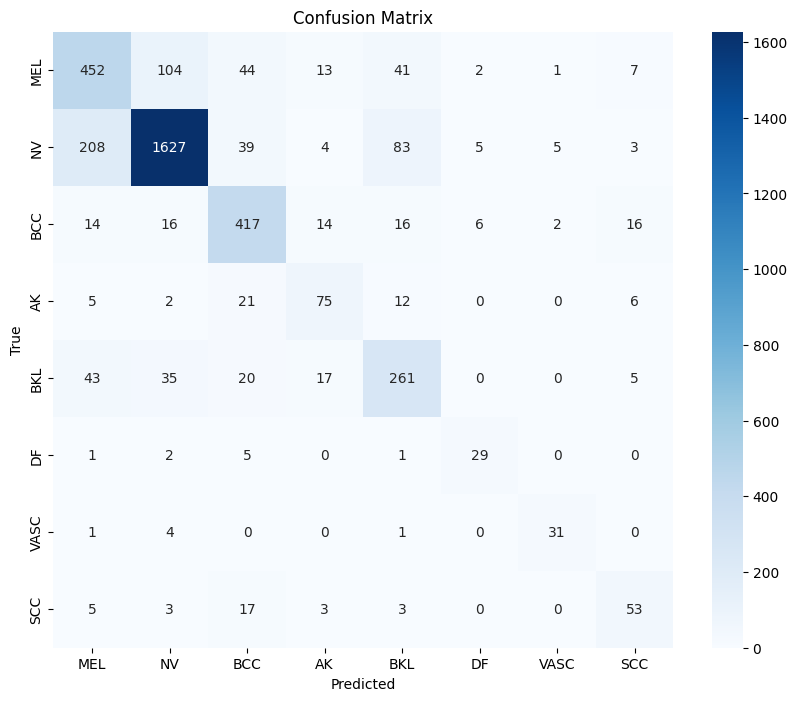

In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Load validation generator WITHOUT shuffle and augmentation
val_csv_path = "/kaggle/input/classification-csv/val.csv"
val_image_dir = "/kaggle/input/classification-skin/content/drive/MyDrive/skin_classification/Classification_Processed/Processed_validate"

model_path = "/kaggle/working/Classification_checkpoints/epoch_55.h5"  # Change to your actual path if needed
model =tf.keras.models.load_model(model_path)
print("✅ Model loaded successfully.")

val_generator = CustomImageGenerator(
    csv_path=val_csv_path,
    image_dir=val_image_dir,
    batch_size=32,
    target_size=(224, 224),
    shuffle=False,
    augment=False
)

# Get predictions
y_pred_proba = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

# Get true labels
y_true = val_generator.labels

# Class names
class_names = val_generator.class_names

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


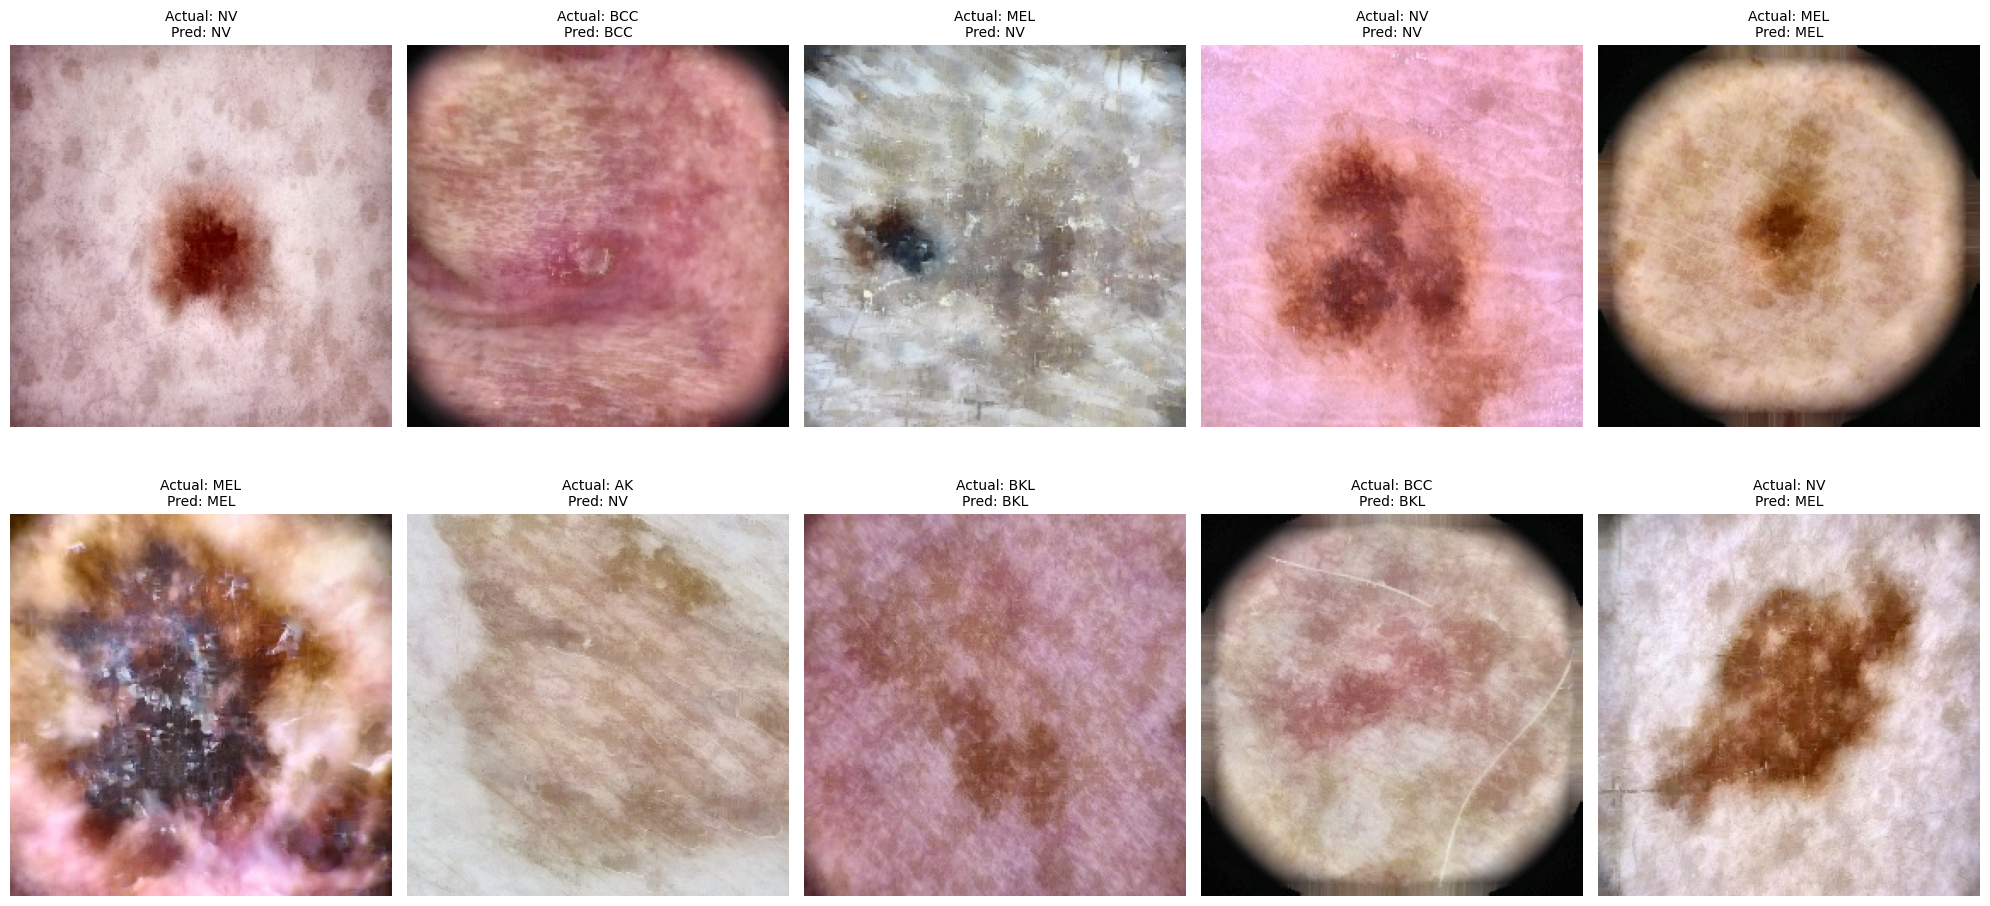

In [17]:
import random
import matplotlib.pyplot as plt

# Pick 10 random indices
random_indices = random.sample(range(len(val_generator.image_filenames)), 10)

plt.figure(figsize=(20, 10))

for i, idx in enumerate(random_indices):
    # Get image info
    image_name = val_generator.image_filenames[idx]
    true_label_index = val_generator.labels[idx]
    true_label_name = val_generator.class_names[true_label_index]
    image_path = os.path.join(val_image_dir, image_name)

    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_normalized = image_rgb / 255.0
    input_image = np.expand_dims(image_normalized, axis=0)

    # Predict
    pred_probs = model.predict(input_image)
    pred_class_index = np.argmax(pred_probs, axis=1)[0]
    pred_class_name = val_generator.class_names[pred_class_index]

    # Plot
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"Actual: {true_label_name}\nPred: {pred_class_name}", fontsize=10)

plt.tight_layout()
plt.show()
